In [122]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [99]:
df_master = pd.read_csv("../data/CASP004-01/masterfile.csv")
df_master['product_brand'] = df_master['product_brand'].str.rstrip()
def correct_product_brand_spacing(df, column_name):
    # Add a space before the slash if it's not there and remove extra spaces after the slash
    df[column_name] = df[column_name].str.replace(r'/', ' / ').str.replace(r'\s+', ' ', regex=True)
    return df

df_master = correct_product_brand_spacing(df_master, 'product_brand')
df_master['material_I'] = df_master['material_I'].str.replace('Bioopolymer', 'Biopolymer')


## Outlier Analysis

In [100]:
df_non_outlier = df_master[df_master['outlier_alert']==False]
len(df_non_outlier)

912

In [101]:
df_outlier = df_master[df_master['outlier_alert']==True]
len(df_outlier)

132

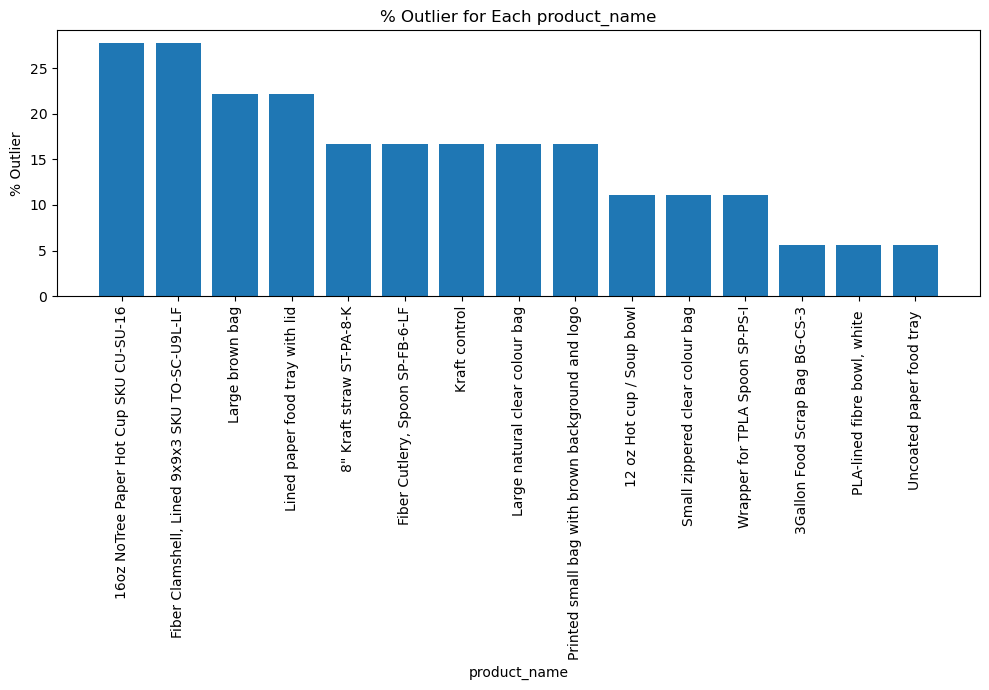

In [102]:
def outlier_plot(col):
    outlier_category = df_outlier.groupby([col])['outlier_alert'].count().reset_index()
    df = df_master.groupby([col])['outlier_alert'].count().reset_index()
    outlier_category = outlier_category.merge(df, on=col)
    outlier_category['%_outlier'] = (outlier_category['outlier_alert_x'] / outlier_category['outlier_alert_y'] * 100).round(2)
    outlier_category = outlier_category.sort_values(by='%_outlier', ascending=False)
    plt.figure(figsize=(10, 7))
    plt.bar(outlier_category[col], outlier_category['%_outlier'])
    plt.title(f'% Outlier for Each {col}')
    plt.xlabel(col)
    plt.ylabel('% Outlier')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()
    
outlier_plot('product_name')


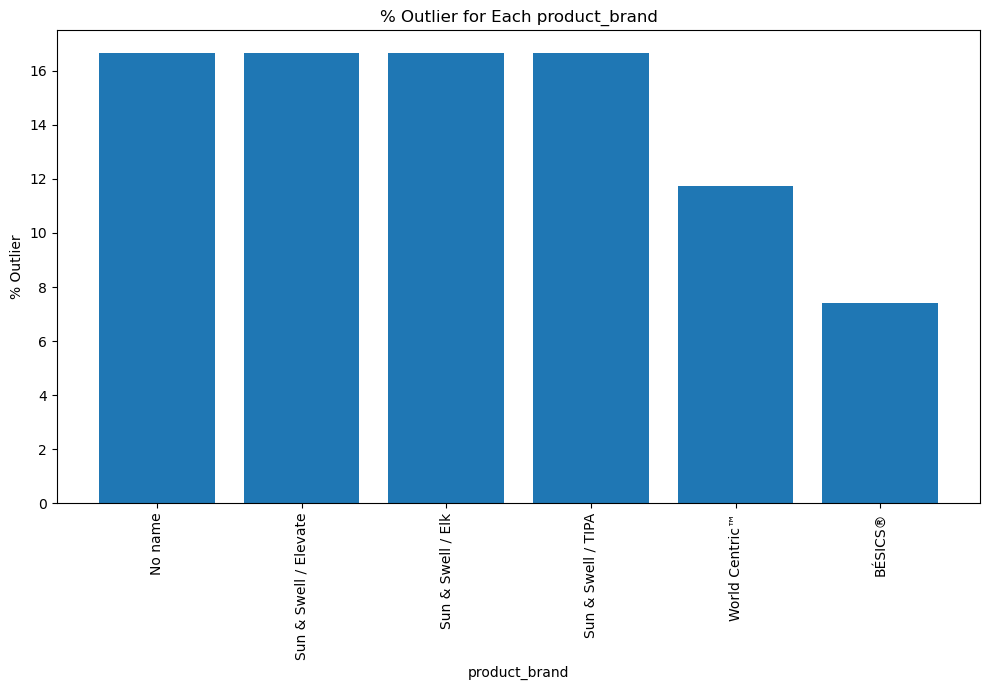

In [103]:
outlier_plot('product_brand')

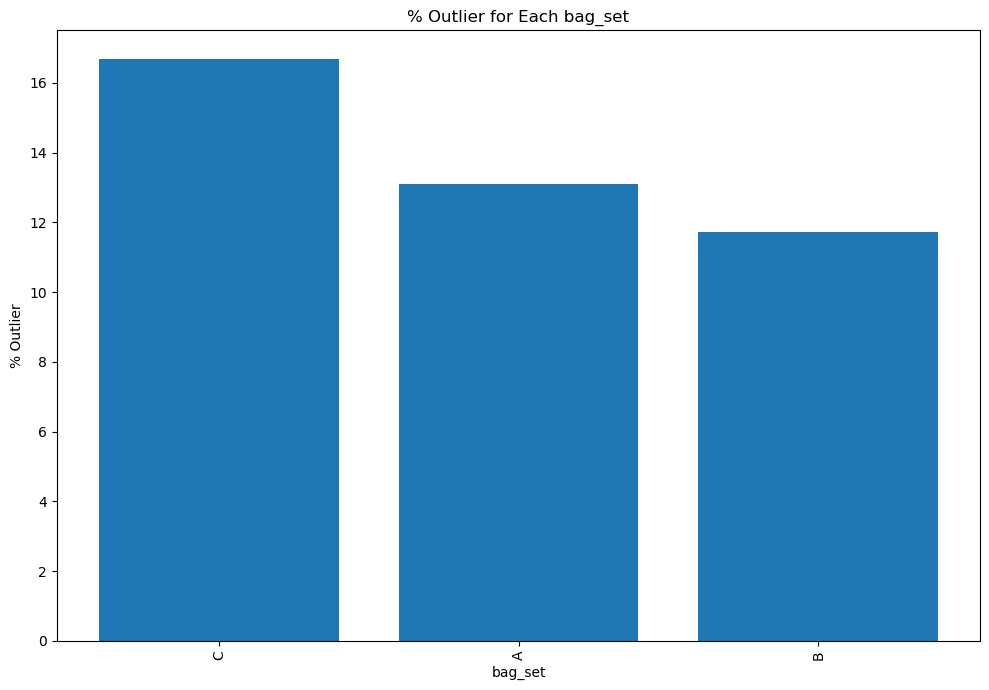

In [104]:
outlier_plot('bag_set')

### Plot Functions Set Up

In [105]:
df_end = df_master[df_master['trial_stage'] == 'End']
df_non_outlier = df_end[df_end['outlier_alert']==False]

def bar_whisker_plot(df, x, y, outlier):
    iqr = df.groupby(x)[y].apply(lambda g: g.quantile(0.75) - g.quantile(0.25))
    nonzero_iqr_order = df[df[x].isin(iqr[iqr > 0].index)].groupby(x)[y].median().sort_values(ascending=False).index
    zero_iqr_order = iqr[iqr == 0].index
    order = nonzero_iqr_order.append(zero_iqr_order)
    plt.figure(figsize=(12, 8))
    unique = df[x].nunique()
    palette = sns.color_palette("husl", unique) 
    sns.boxplot(data=df, x=x, y=y, order=order, palette=palette)
    plt.title(f'{y} for Each {x} {outlier}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

def plot_violin(df, x, y):
    plt.figure(figsize=(8, 5))
    sns.violinplot(x=x, y=y, data=df, palette="viridis")
    plt.title('Violin Plot of % Residual for Each {x} Type')
    plt.xlabel(x)
    plt.ylabel(y)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

## Average Weight Pre and Post Composting

/tmp/ipykernel_2956/2330518208.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stages_ordered = df_master.groupby(['product_name', 'trial_stage'])['mean_weight_final_g'].mean().reset_index().round(2)


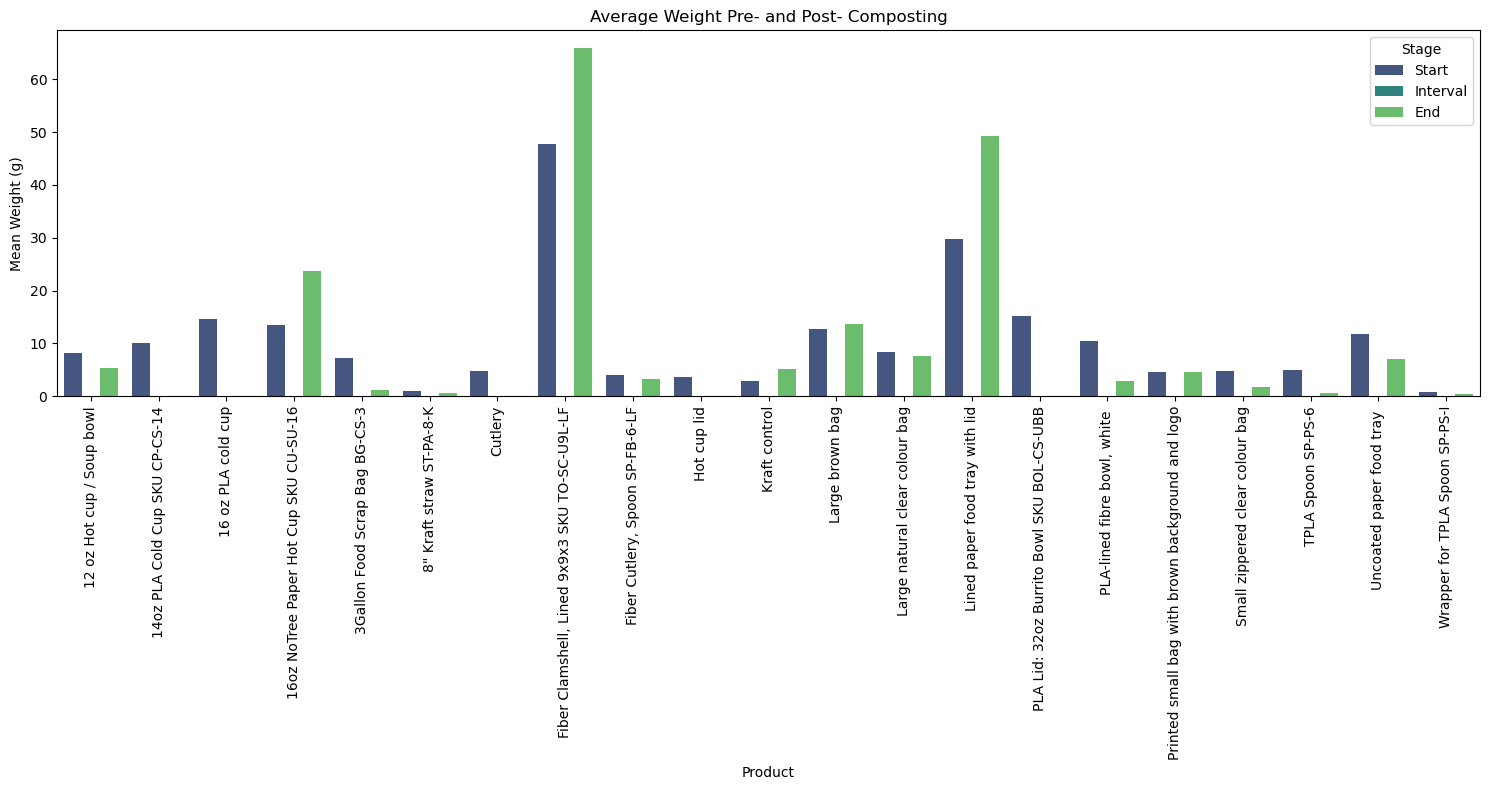

In [106]:
stage_order = pd.CategoricalDtype(
    categories=["Start", "Interval", "End"],
    ordered=True
)
df_master['trial_stage'] = df_master['trial_stage'].astype(stage_order)

stages_ordered = df_master.groupby(['product_name', 'trial_stage'])['mean_weight_final_g'].mean().reset_index().round(2)
plt.figure(figsize=(15, 8))
sns.barplot(x='product_name', y='mean_weight_final_g', hue='trial_stage', data=stages_ordered, palette="viridis")
plt.title('Average Weight Pre- and Post- Composting')
plt.xlabel('Product')
plt.ylabel('Mean Weight (g)')
plt.xticks(rotation=90)
plt.legend(title='Stage')
plt.tight_layout()
plt.show()


- As the CASP004-001 trial lacks data for the interval stage, the plot displays the average weight change of products by comparing the mean weight from start to the end of the trial. Notably, while some products completely decomposed, others, such as the 16oz No Tree Paper Hot Cup and the Fiber Clamshell, actually gained weight.

- Therefore, we tagged the products that add weight during decomposition as **anomalies**.

    For each observation, we check whether the final post-decomposition weight is smaller than the original manufacturing weight of the product tested. If this is not true, this product likely clumped with other products and represents an anomaly. We tagged it as an anomaly (column `outlier_alert`) so that we can perform anomaly specific analyses downstream. 

## % Residual by Products

- In this analysis, we have plotted the percentage of residuals by products for all data, as well as for data excluding anomalies. 

- Products are arranged on the x-axis according to their median values. 

/tmp/ipykernel_2956/2278005699.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=x, y=y, order=order, palette=palette)


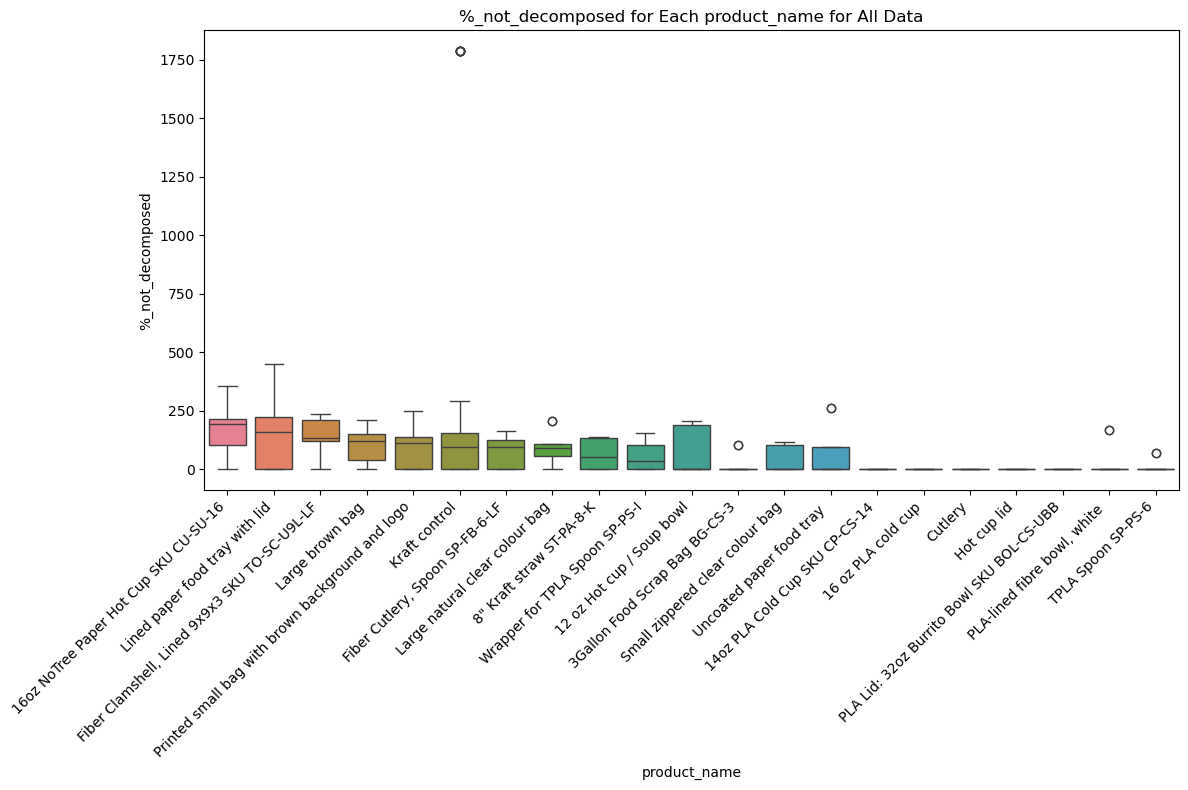

In [107]:
bar_whisker_plot(df_end, 'product_name', '%_not_decomposed', 'for All Data')

- From the first plot, it is evident that the 'kraft control' product shows an exceptionally high percentage of non-decomposition, specifically 1750%. This extreme value could potentially affect other aspects of the plot, i.e. scaling.

/tmp/ipykernel_2956/2278005699.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=x, y=y, order=order, palette=palette)


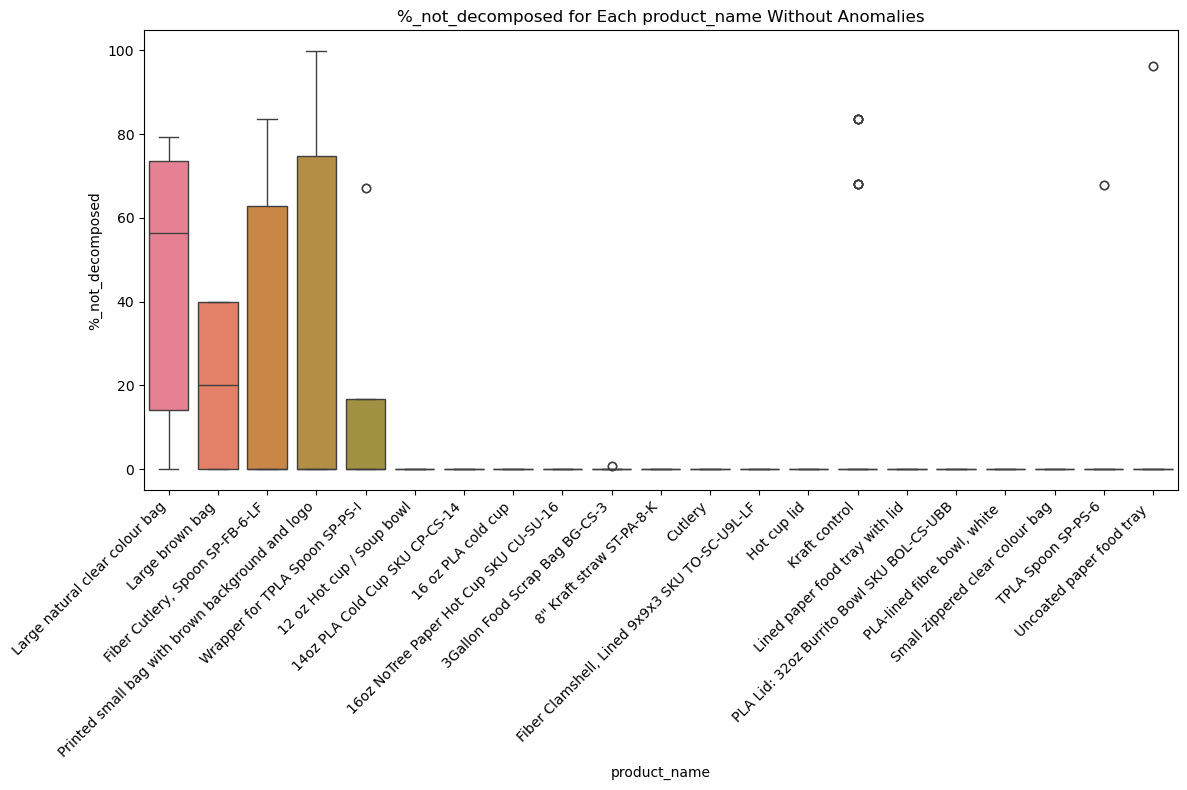

In [108]:
bar_whisker_plot(df_non_outlier, 'product_name', '%_not_decomposed', 'Without Anomalies')

- In the second plot, where all anomalies have been removed, we observe that the majority of the products have completely decomposed, indicated by their minimum, 25th percentile, median, and 75th percentile values all registering at 0. This results in them converging into a single line at 0.

## % Residual by Material Class I


In [139]:
from adjustText import adjust_text

def bar_whisker_plot_annotate(df, x, y, outlier):
    df = df.dropna(subset=[x, y, 'product_name']) 

    # Calculate Interquartile Range (IQR) for each group
    iqr = df.groupby(x)[y].apply(lambda g: g.quantile(0.75) - g.quantile(0.25))
    
    # Determine the order of x-axis categories based on non-zero IQR
    nonzero_iqr_order = df[df[x].isin(iqr[iqr > 0].index)].groupby(x)[y].median().sort_values(ascending=False).index
    zero_iqr_order = iqr[iqr == 0].index
    order = nonzero_iqr_order.append(zero_iqr_order)
    
    # Create the boxplot
    plt.figure(figsize=(12, 8))
    unique = df[x].nunique()
    palette = sns.color_palette("husl", unique) 
    sns.boxplot(data=df, x=x, y=y, order=order, palette=palette)
    
    # Calculate Q1, Q3 for identifying outliers
    Q1 = df.groupby(x)[y].apply(lambda g: g.quantile(0.25))
    Q3 = df.groupby(x)[y].apply(lambda g: g.quantile(0.75))
    IQR = Q3 - Q1
    threshold = 1.5  # Outlier threshold; adjust as needed

    # Identify outliers
    outliers = df.apply(lambda row: row[y] > Q3[row[x]] + threshold * IQR[row[x]] or
                                     row[y] < Q1[row[x]] - threshold * IQR[row[x]], axis=1)
    outlier_data = df[outliers]

    for index, row in outlier_data.iterrows():
        x_coord = order.tolist().index(row[x])

        # Dynamically adjust the y-offset
        y_offset = 10 if index % 2 == 0 else -20  # Alternate offset

        plt.annotate(row['product_name'],
                     xy=(x_coord, row[y]),
                     xytext=(0, y_offset),
                     textcoords='offset points',
                     ha='center',
                     va='bottom' if y_offset > 0 else 'top')

    # Set plot title and adjust x-ticks
    plt.title(f'{y} for Each {x} {outlier}')
    plt.xticks(rotation=45, ha='right')

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_2956/1447255498.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=x, y=y, order=order, palette=palette)


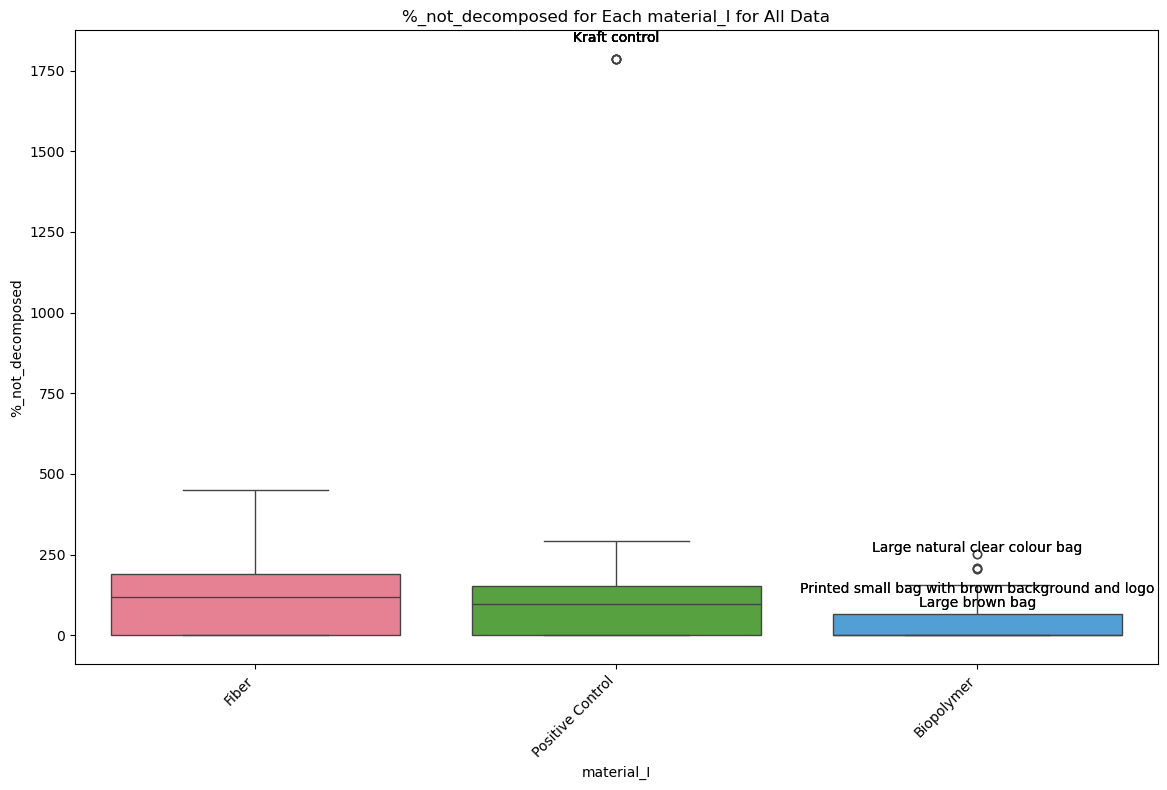

In [140]:
bar_whisker_plot_annotate(df_end, 'material_I', '%_not_decomposed', 'for All Data')

- The findings show fiber with the highest residuals, followed by positive control, and biopolymers with the least. 

/tmp/ipykernel_2956/1447255498.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=x, y=y, order=order, palette=palette)


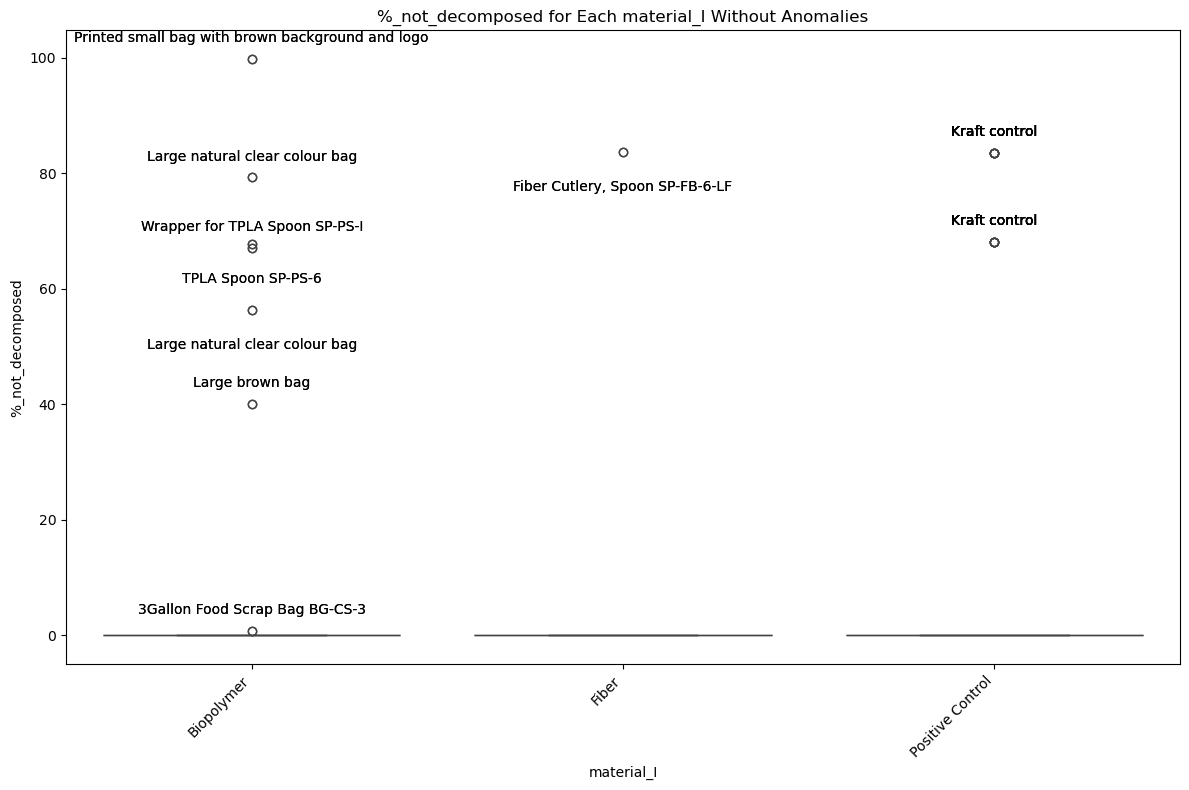

In [141]:
bar_whisker_plot_annotate(df_non_outlier, 'material_I', '%_not_decomposed', 'Without Anomalies')

- Without anomalies, all materials show zero residuals, but biopolymers exhibit more outliers than fiber. 

/tmp/ipykernel_2956/2278005699.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=x, y=y, data=df, palette="viridis")


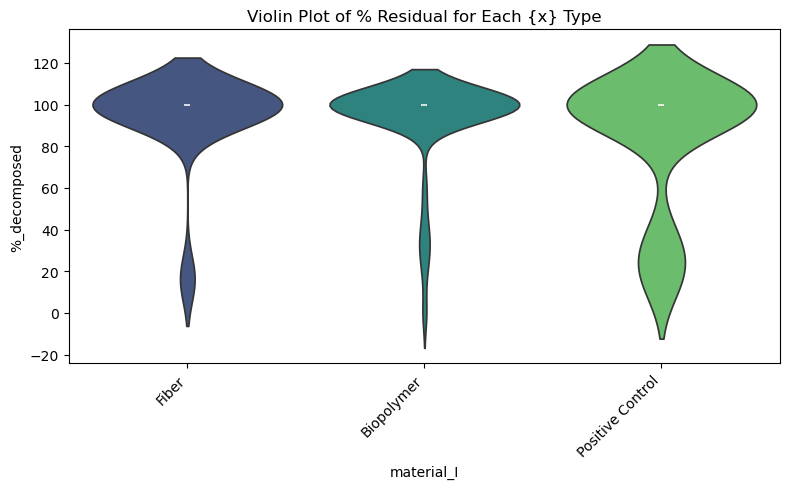

In [142]:
plot_violin(df_non_outlier, 'material_I', '%_decomposed')

## % Residual by Material Class II


/tmp/ipykernel_2956/1447255498.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=x, y=y, order=order, palette=palette)


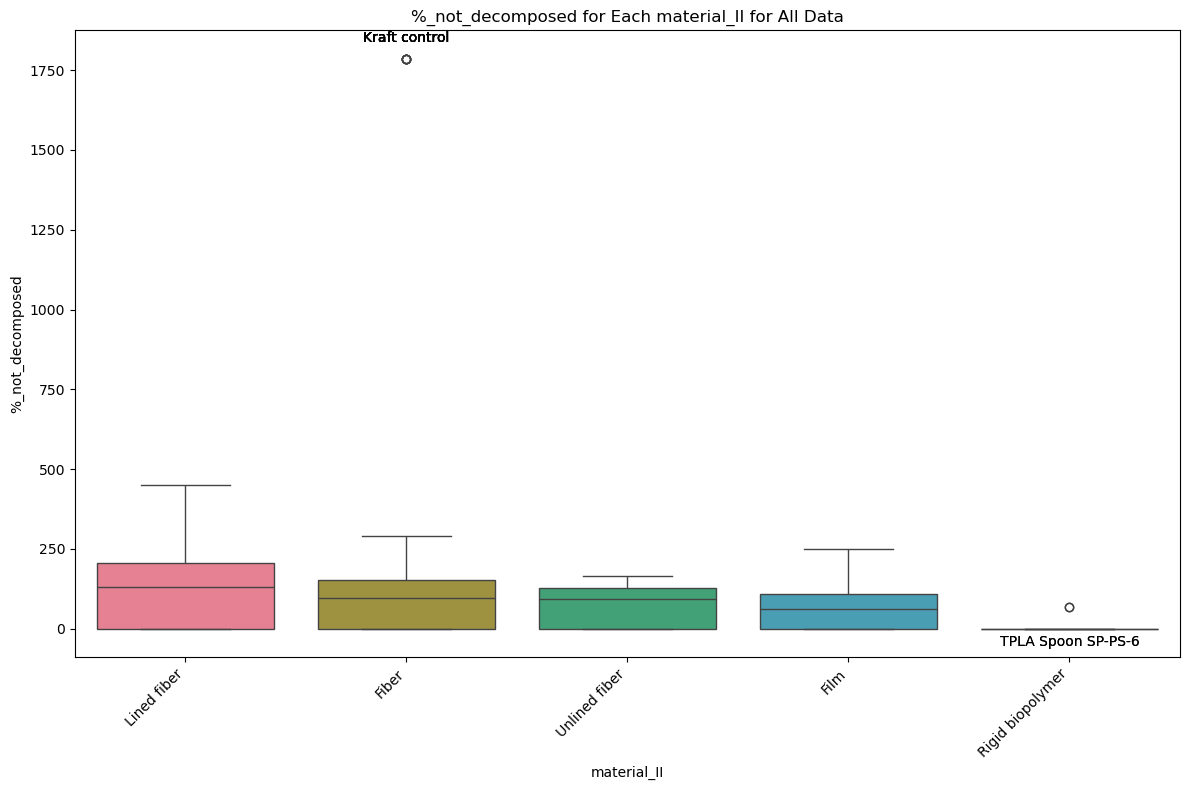

In [143]:
bar_whisker_plot_annotate(df_end, 'material_II', '%_not_decomposed', 'for All Data')

/tmp/ipykernel_2956/1447255498.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=x, y=y, order=order, palette=palette)


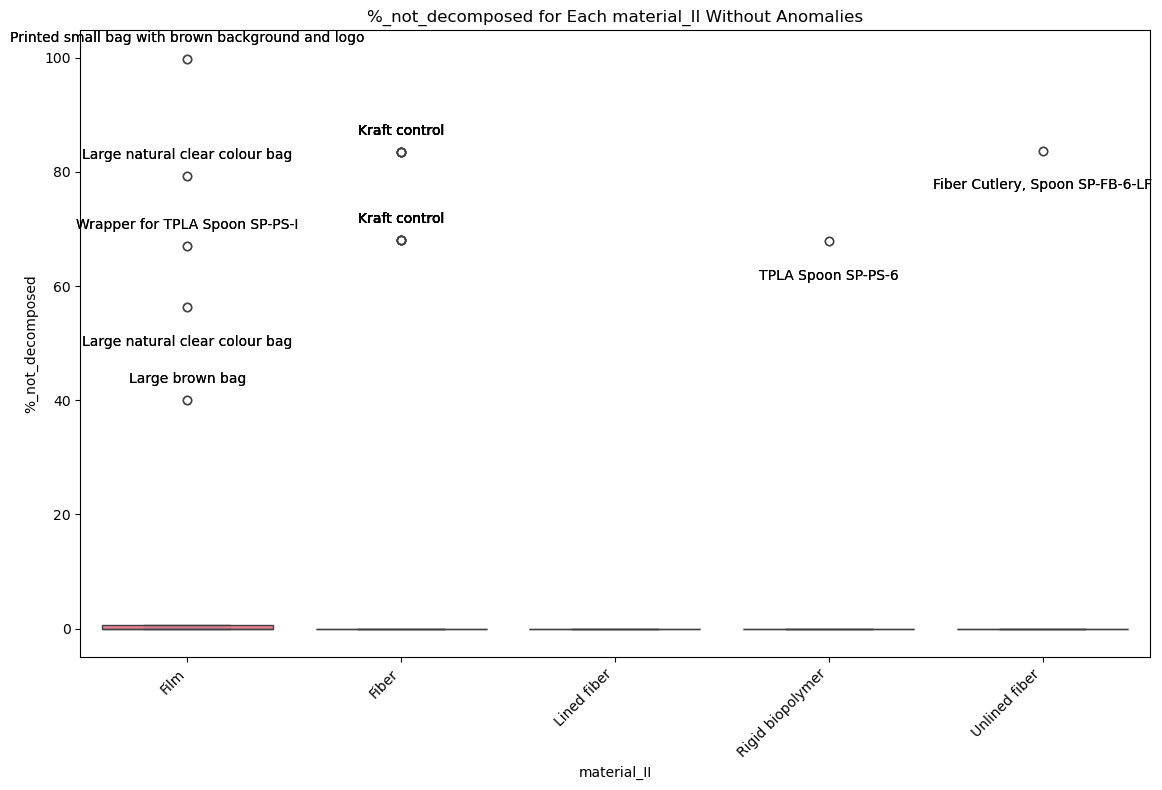

In [144]:
bar_whisker_plot_annotate(df_non_outlier, 'material_II', '%_not_decomposed', 'Without Anomalies')

/tmp/ipykernel_2956/2278005699.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=x, y=y, data=df, palette="viridis")


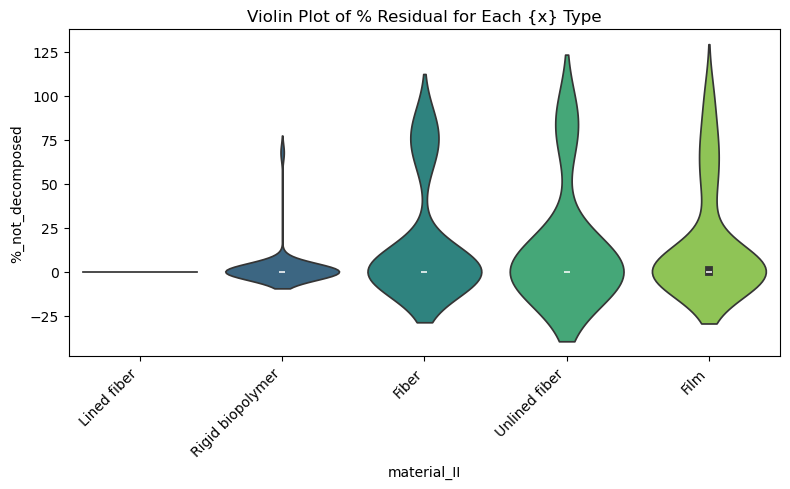

In [145]:
plot_violin(df_non_outlier, 'material_II', '%_not_decomposed')

## % Residual by Material Class III

/tmp/ipykernel_2956/1447255498.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=x, y=y, order=order, palette=palette)


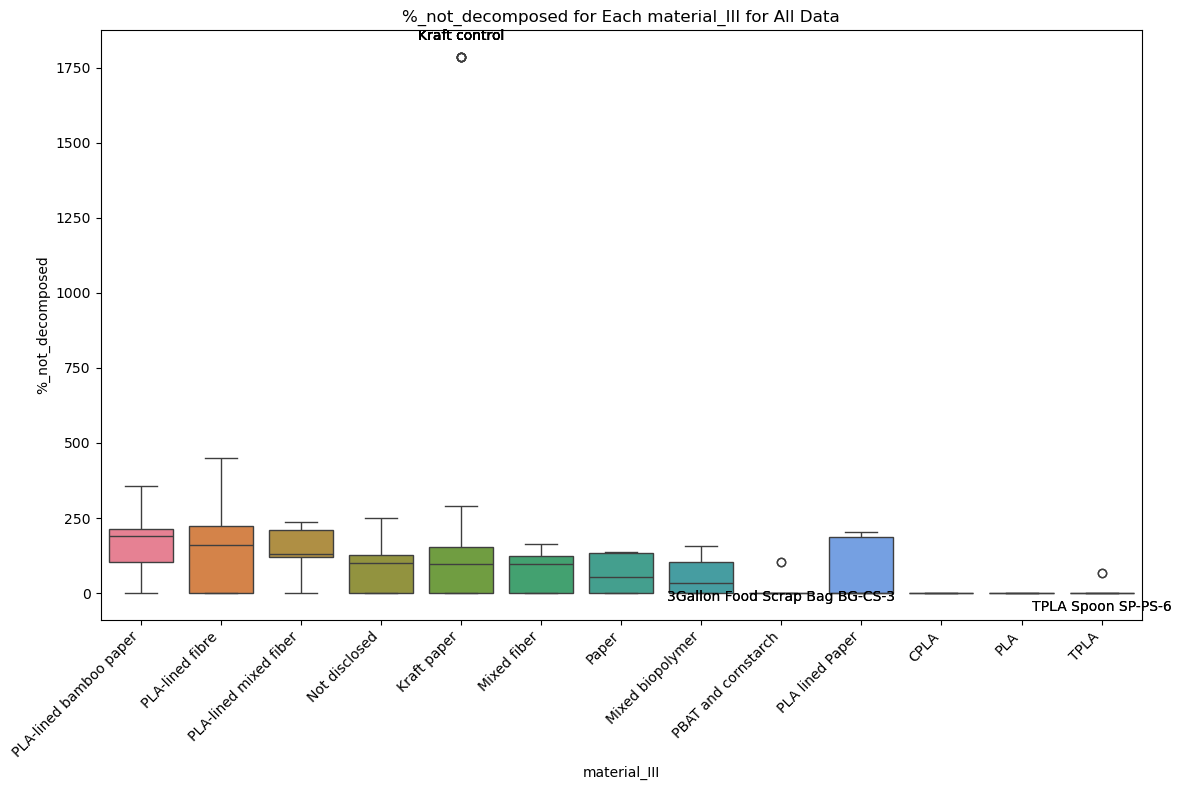

In [146]:
bar_whisker_plot_annotate(df_end, 'material_III', '%_not_decomposed', 'for All Data')

/tmp/ipykernel_2956/1447255498.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=x, y=y, order=order, palette=palette)


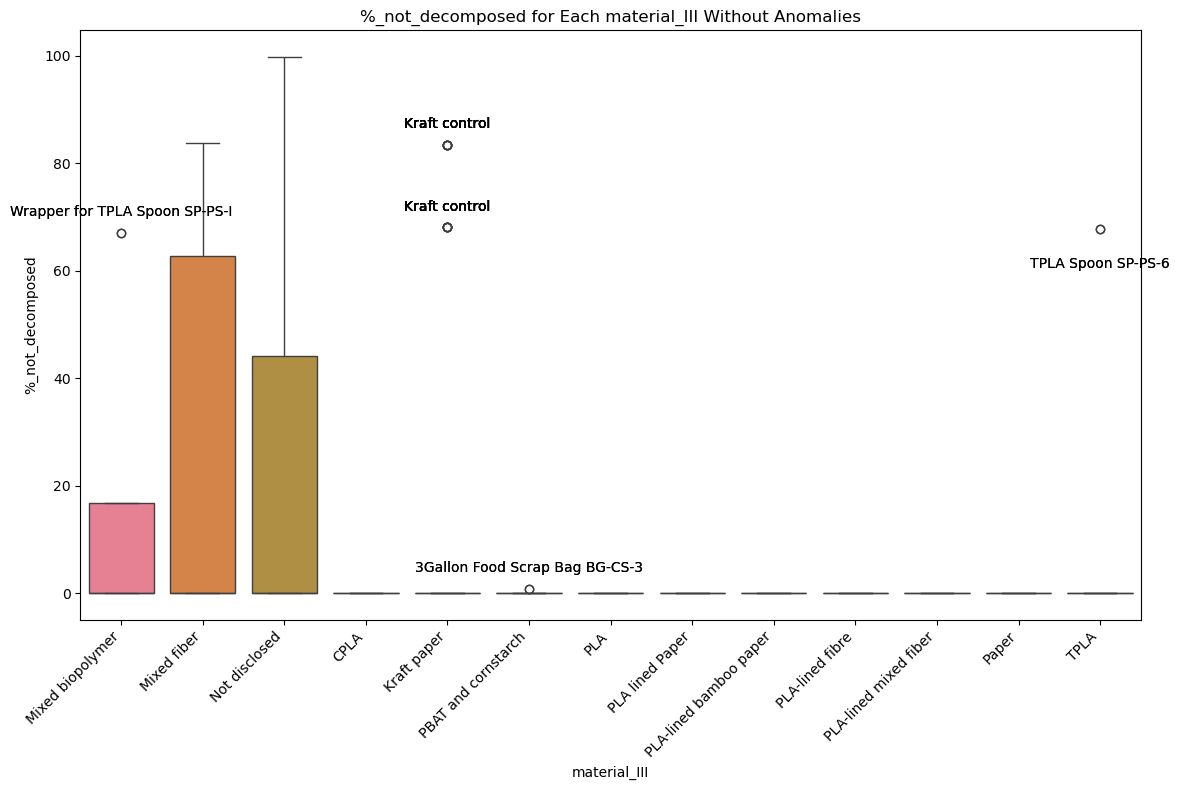

In [147]:
bar_whisker_plot_annotate(df_non_outlier, 'material_III', '%_not_decomposed', 'Without Anomalies')

## % Residual by Product Brand

/tmp/ipykernel_2956/1447255498.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=x, y=y, order=order, palette=palette)


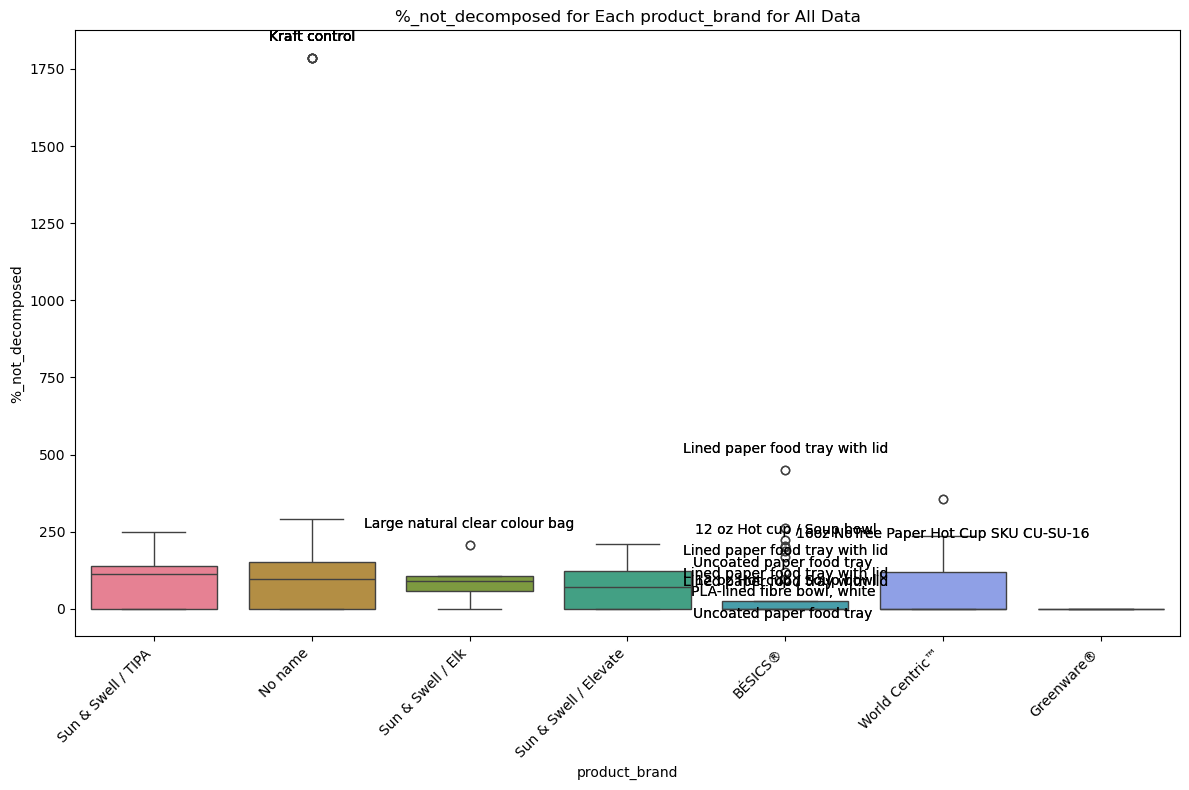

In [148]:
bar_whisker_plot_annotate(df_end, 'product_brand', '%_not_decomposed', 'for All Data')

/tmp/ipykernel_2956/1447255498.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=x, y=y, order=order, palette=palette)


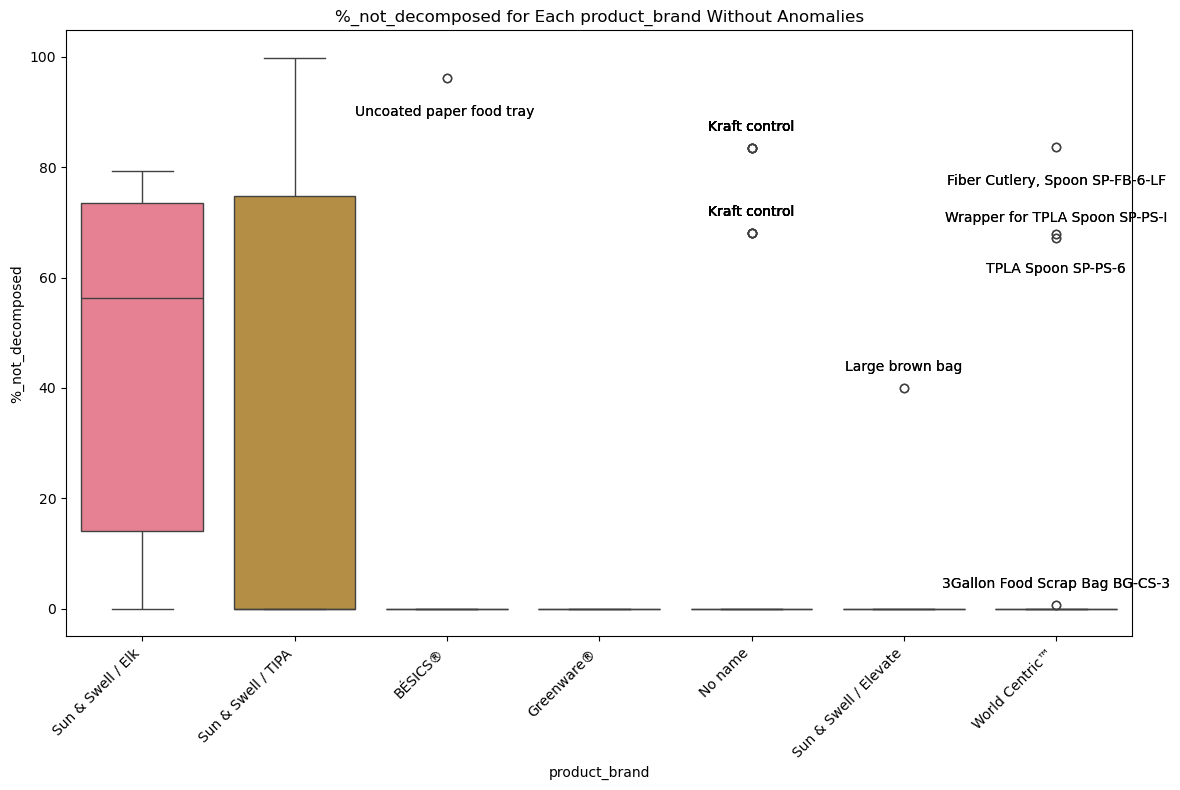

In [149]:
bar_whisker_plot_annotate(df_non_outlier, 'product_brand', '%_not_decomposed', 'Without Anomalies')

## % Residual by Bag Placement (Top vs. Bottom)

/tmp/ipykernel_2956/1447255498.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=x, y=y, order=order, palette=palette)


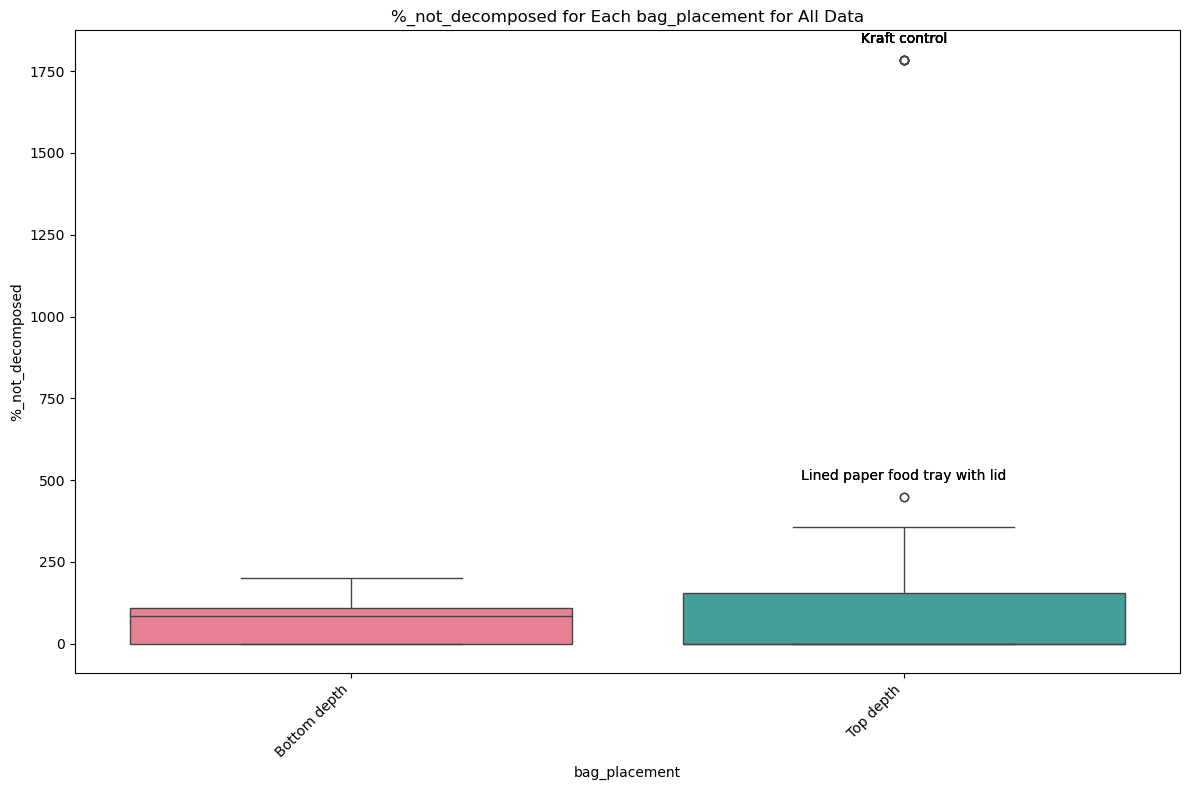

In [150]:
bar_whisker_plot_annotate(df_end, 'bag_placement', '%_not_decomposed', 'for All Data')

/tmp/ipykernel_2956/1447255498.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=x, y=y, order=order, palette=palette)


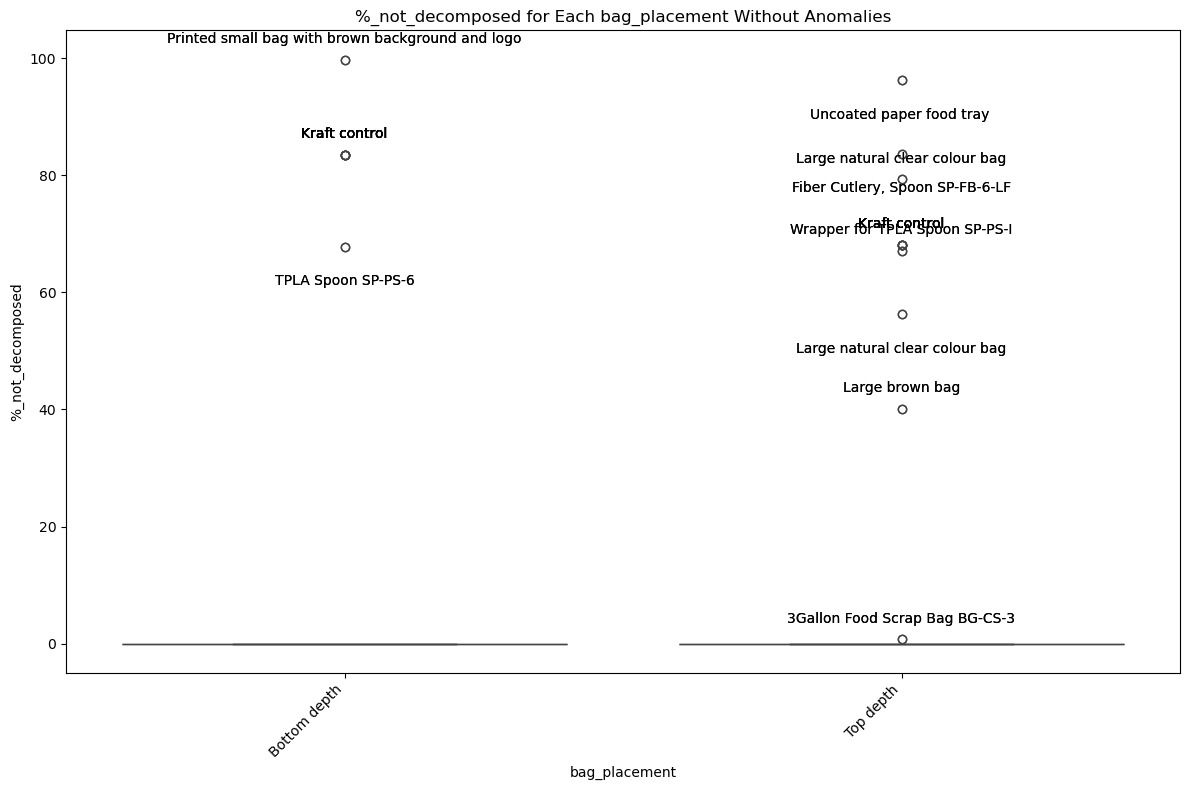

In [151]:
bar_whisker_plot_annotate(df_non_outlier, 'bag_placement', '%_not_decomposed', 'Without Anomalies')

## Actual Distribution Plot by Material

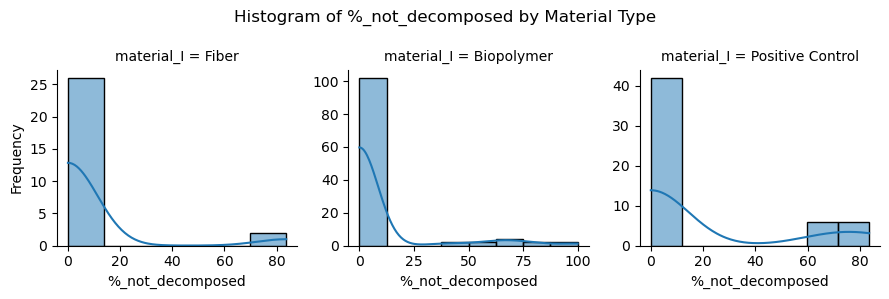

In [152]:
def plot_distribution(df, x, y):
    g = sns.FacetGrid(df, col=x, col_wrap=3, sharex=False, sharey=False) 
    g.map(sns.histplot, y, kde=True)  # KDE=True adds a density line

    g.fig.suptitle(f'Histogram of {y} by Material Type') 
    g.set_axis_labels(y, 'Frequency')

    g.tight_layout()
    plt.show()

plot_distribution(df_non_outlier, 'material_I', '%_not_decomposed')